### Run cloud cover detection @ CUES

Following a method similar to the clear-sky index of Marty & Philipona (2000), I am trying to determine when we have clouds over thes CUES site by comparing an estimated clear-sky downward longwave radiation (LWd) against observed ("all sky") LWd.

We expect observed LWd to be greater than estimated clear-sky LWd when we have cloud-cover. This should be especially useful for identifying cloud-cover during nighttime when we don't have shortwave solar radiation to also check if we have sunny or cloudy skies. 

But where do we draw the classification threshold line between cloud and not cloudy? I test a range of threshold values, and compute a confusion matrix for the time periods when we have cloud cover observations we can use to verify our method's performance. (We have cloud cover observations in the daytime, when a solar pyranometer could detect decreases in downward shortwave radiation).

We can also take a look at the GOES-16 ABI IR observations from the same time, where we expect to see cold cloud-tops when they pass over the site, and see how well our cloud detection method matches the satellite observations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

Import the cloud_detect functions:

In [3]:
import cloud_detect

Define functions we'll use

In [4]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
---
Load observations from CUES site:

In [5]:
cues_ds = pd.read_pickle('data/CUES_L1_Temp_Rad_Snowdepth_2017-2020.pkl').to_xarray()

#### Run cloud detection function:

Set up input variables from CUES observations.

In [6]:
RH = cues_ds['Platform relative humidity; platform temperature/relative humidity; (percent)']
T = cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
Ta = T + 273.15 # temperature [K]
LWd_obs = cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
sun_flag_obs = cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']
elev = 2940 # meters
lw_threshold = 13.67 #28.72
csi_threshold = 0.067 #0.026

In [7]:
LWd_pred, confusion_matrix, precision, recall, f1_score = cloud_detect.lw_cloud_detect(Ta, RH, LWd_obs, sun_flag_obs, elev, lw_threshold, csi_threshold)

In [8]:
confusion_matrix

Predicted,0.0,1.0
Observed,,
0.0,95379,113777
1.0,11789,282099


In [9]:
f1_score

0.8179580262234619

Note: the CUES sun flag used in the confusion matrix isn't present past Oct. 6th 2019, therefore this confusion matrix isn't correct. Our f1-score is probably quite a bit higher.

If we want to, we can compute a confusion matrix for the period of time up until Oct. 2019 where we actually have validation data.

In [10]:
_, test_confusion_matrix, test_precision, test_recall, test_f1_score = cloud_detect.lw_cloud_detect(Ta.loc[Ta.datetime < np.datetime64('2019-10')], 
                                                                                                    RH.loc[RH.datetime < np.datetime64('2019-10')], 
                                                                                                    LWd_obs.loc[LWd_obs.datetime < np.datetime64('2019-10')], 
                                                                                                    sun_flag_obs.loc[sun_flag_obs.datetime < np.datetime64('2019-10')], 
                                                                                                    elev, lw_threshold, csi_threshold)

In [11]:
test_confusion_matrix

Predicted,0.0,1.0
Observed,,
0.0,68810,29708
1.0,11789,279757


In [12]:
test_f1_score

0.9309546747064529

This looks very good!

***
***

### Add the results to the CUES dataset, and export to a file

In [13]:
cues_ds = xr.merge([cues_ds, LWd_pred])

In [14]:
cues_ds.to_dataframe().to_pickle('data/CUES_L1_Temp_Rad_Snowdepth_2017-2020_lw.pkl')

---
---
# Plot results:

Set up font sizes for plot

In [19]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#### Visualize how well this works in daytime by comparing with our sun flag:


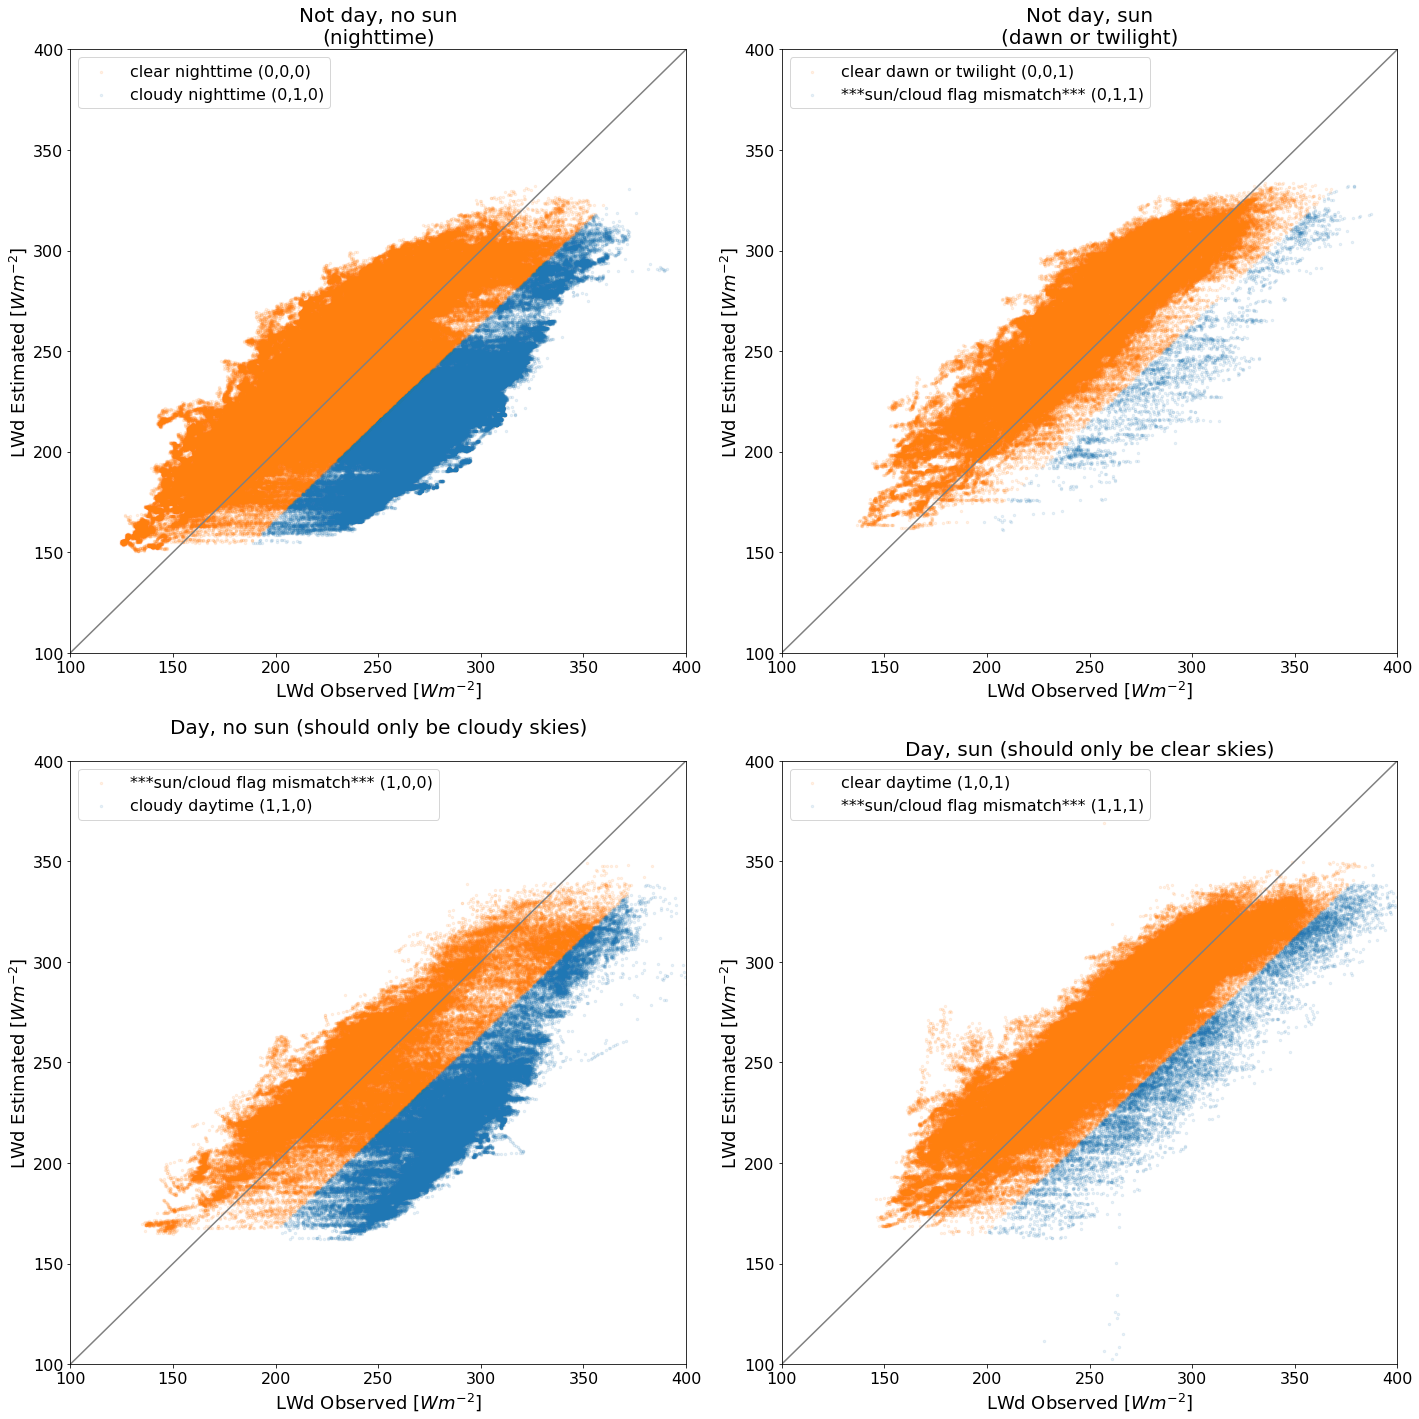

In [20]:
fig, ax = plt.subplots(2,2,figsize=(20,20))



### Not daytime, no sun
# Not day, no clouds, no sun (nighttime clear skies)
condition = (cues_ds.day_flag==0) & (cues_ds.cloud_flag==0) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==0)
ax[0,0].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:orange', alpha=0.1, label='clear nighttime (0,0,0)')
# Not day, clouds, no sun (nighttime cloudy skies)
condition = (cues_ds.day_flag==0) & (cues_ds.cloud_flag==1) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==0)
ax[0,0].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:blue', alpha=0.1, label='cloudy nighttime (0,1,0)')
ax[0,0].plot([0,400],[0,400],'-',c='grey')
ax[0,0].set_xlim([100,400])
ax[0,0].set_ylim([100,400])
ax[0,0].set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax[0,0].set_xlabel('LWd Observed [$Wm^{-2}$]')
ax[0,0].set_title('Not day, no sun\n(nighttime)')
ax[0,0].legend()



### Not daytime, sun
# Not day, no clouds, sun (we shouldn't see much here (early morning or late afternoon only))
condition = (cues_ds.day_flag==0) & (cues_ds.cloud_flag==0) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
ax[0,1].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:orange', alpha=0.1, label='clear dawn or twilight (0,0,1)')
# Not day, clouds, sun (we shouldnt see much here)
condition = (cues_ds.day_flag==0) & (cues_ds.cloud_flag==1) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
ax[0,1].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:blue', alpha=0.1, label='***sun/cloud flag mismatch*** (0,1,1)')
ax[0,1].plot([0,400],[0,400],'-',c='grey')
ax[0,1].set_xlim([100,400])
ax[0,1].set_ylim([100,400])
ax[0,1].set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax[0,1].set_xlabel('LWd Observed [$Wm^{-2}$]')
ax[0,1].set_title('Not day, sun\n(dawn or twilight)')
ax[0,1].legend()




### Daytime, no sun
# Day, no clouds, no sun (we shouldnt see much here)
condition = (cues_ds.day_flag==1) & (cues_ds.cloud_flag==0) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==0)
ax[1,0].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:orange', alpha=0.1, label='***sun/cloud flag mismatch*** (1,0,0)')
# Day, clouds, no sun (daytime cloudy skies)
condition = (cues_ds.day_flag==1) & (cues_ds.cloud_flag==1) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==0)
ax[1,0].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:blue', alpha=0.1, label='cloudy daytime (1,1,0)')
ax[1,0].plot([0,400],[0,400],'-',c='grey')
ax[1,0].set_xlim([100,400])
ax[1,0].set_ylim([100,400])
ax[1,0].set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax[1,0].set_xlabel('LWd Observed [$Wm^{-2}$]')
ax[1,0].set_title('Day, no sun (should only be cloudy skies)\n')
ax[1,0].legend()



### Daytime, sun
# Day, no clouds, sun (clear skies)
condition = (cues_ds.day_flag==1) & (cues_ds.cloud_flag==0) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
ax[1,1].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:orange', alpha=0.1, label='clear daytime (1,0,1)')
# Day, clouds, sun (we shouldnt see much here)
condition = (cues_ds.day_flag==1) & (cues_ds.cloud_flag==1) & (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
ax[1,1].scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']\
           .where(condition),
           cues_ds.lclr_mean.where(condition),
          s=6, c='tab:blue', alpha=0.1, label='***sun/cloud flag mismatch*** (1,1,1)')
ax[1,1].plot([0,400],[0,400],'-',c='grey')
ax[1,1].set_xlim([100,400])
ax[1,1].set_ylim([100,400])
ax[1,1].set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax[1,1].set_xlabel('LWd Observed [$Wm^{-2}$]')
ax[1,1].set_title('Day, sun (should only be clear skies)')
ax[1,1].legend()
                  

plt.tight_layout()

**Plot along with GOES data**

Load GOES observations for the CUES site

In [24]:
directory = '/storage/GOES/pkl/CUES'
goes_files = getListOfFiles(directory)

goes = []
_ = [goes.append(pd.read_pickle(i)) for i in goes_files]
goes = pd.concat(goes)

# Change GOES time values from UTC to UTC-7 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC'})
goes['datetime'] = goes['timeUTC'] - pd.Timedelta(hours=7)
goes = goes.drop(columns=['timeUTC'])

# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_goes = goes.set_index('datetime')
_goes.sort_index(inplace=True)
_goes = _goes.loc[~_goes.index.duplicated(keep='first')] # there are duplicates somewhere in the GOES data, remove them
_goes = _goes.loc[_goes.index >= pd.datetime(2017,2,28)]# there are also some values before 2017, remove them
goes_ds = _goes.to_xarray()

Plot some results zoomed in to a couple days:

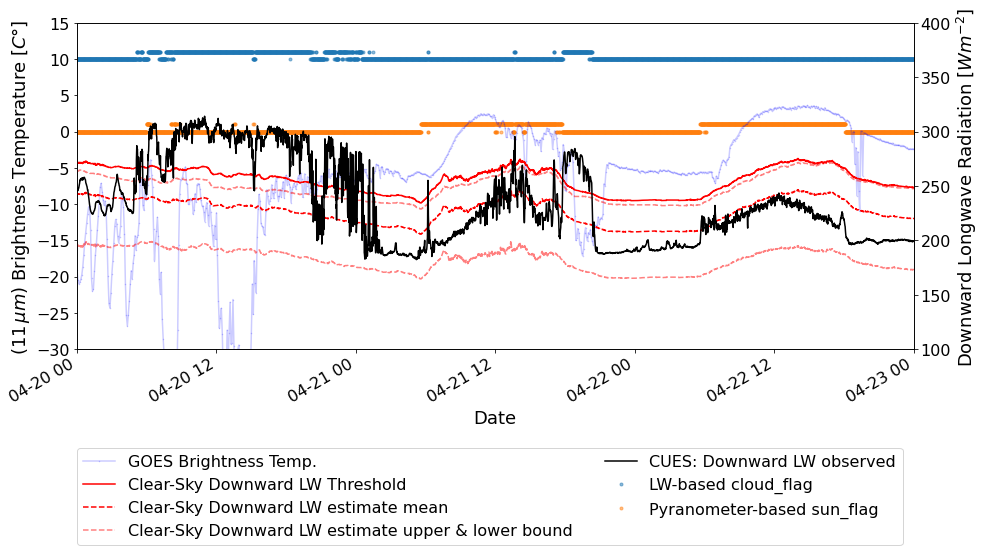

In [26]:
# Set start and end dates for time period we want to look at
#startdate = pd.datetime(2017,3,15)
#enddate = pd.datetime(2017,3,20)
startdate = pd.Timestamp(2019,4,20)
enddate = pd.Timestamp(2019,4,23)

fig, ax = plt.subplots(figsize=(15,6))


ax2 = ax.twinx()

ax2.plot(cues_ds.datetime, cues_ds.lclr_mean + lw_threshold,alpha=1,c='r', linestyle='-')
cues_ds.lclr_mean.plot(ax=ax2,alpha=1,c='r', linestyle='--')
cues_ds.lclr_max.plot(ax=ax2,alpha=0.5,c='r', linestyle='--')
cues_ds.lclr_min.plot(ax=ax2,alpha=0.5,c='r', linestyle='--')
#ax2.fill_between(cues_ds.datetime, cues_ds.lclr_max, cues_ds.lclr_min,color='r',alpha=0.2)


# Observed Downward Lognwave Radiation
cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'].plot(ax=ax2, c='k')

# sun/cloud/day flags
ax.plot(cues_ds.datetime, cues_ds.cloud_flag+10,linestyle='none',marker='.', alpha=0.5)
#cues_ds.day_flag.plot(ax=ax,linestyle='none',marker='.')
cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'].plot(ax=ax,linestyle='none',marker='.', alpha=0.5)

# Fill in areas CUES identifies as sunny versus not sunny
#sun_flag = cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'] == 1
#cues_nosun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=~sun_flag, color='lightgrey',alpha=0.1)
#cues_sun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=sun_flag, color='lightyellow',alpha=0.1)
#
#cloud_flag = cues_ds['Lclr'] < cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
#cloud = ax.fill_between(cues_rad_data.datetime, 1000, y2=0, where=cloud_flag, color='red',alpha=0.1)

# GOES brightness temperature
goes_ds.tb.plot(c='b', linestyle='-', marker='.', markersize=1, ax=ax, alpha=0.2)

#ax.set_xlim((cues_rad.datetime.min(),cues_rad.datetime.max()))
ax.set_xlim([startdate,enddate])
ax2.set_ylim((100,400))
ax.set_ylim((-30,15))

ax.set_ylabel('($11 \, \mu m$) Brightness Temperature [$C\degree$]')
ax.set_xlabel('Date')
ax2.set_ylabel('Downward Longwave Radiation [$W m^{-2}$]');

# make legend
lines = [ax.lines[2], 
         ax2.lines[0], ax2.lines[1], ax2.lines[2],
          ax2.lines[4],
        ax.lines[0], ax.lines[1]]
labels = ['GOES Brightness Temp.', 
          'Clear-Sky Downward LW Threshold','Clear-Sky Downward LW estimate mean','Clear-Sky Downward LW estimate upper & lower bound', 
          'CUES: Downward LW observed',
         'LW-based cloud_flag', 'Pyranometer-based sun_flag']
ax.legend(lines, labels, loc=(0,-0.6), ncol=2);

---
---